In [125]:
from glob import glob
import os
from os.path import basename, splitext
import pandas as pd
from datetime import datetime
from pytz import timezone
import shapefile
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt

In [126]:
# parameters
sf_path = "data/points_akl.shp"
data_dir="results"
tz = timezone("Pacific/Auckland")

In [316]:
# data loading and sanity checking

# shapefile
points = shapefile.Reader(sf_path)
npt = len(points.records())
print(f"Loaded shapefile with {npt} points")

# odt spatial index
geoids = sorted([r[0] for r in points.records()])
loc_idx = {g:i for i, g in enumerate(geoids)}
assert len(loc_idx) == npt, "Shapefile may contain duplicate identifiers"

file_paths = glob(os.path.join(data_dir, "*.csv"))
nf = len(file_paths)
                                  
# generate time index
query_times = [splitext(basename(f))[0] for f in file_paths]
query_times = [datetime(*map(int, t.split('_')[1:])) for t in query_times]
query_times = sorted(set(query_times))
t_idx = {t:i for i, t in enumerate(sorted(set(query_times)))}
nt = len(t_idx)
assert nf == nt * npt, f"Number of result files {nf} should equal the number of time indices '{nt}' times number of points '{npt}'"

print(f"Found {nf} files representing {npt} points at {nt} time slices")
print(f"Estimated cube size {nt * npt * npt * 4 / (1024 ** 2):.1f} MiB")

Loaded shapefile with 2011 points
Found 4022 files representing 2011 points at 2 time slices
Estimated cube size 30.9 MiB


In [128]:
def load_result(file_path):
           
    # process filename
    bn = os.path.basename(file_path)
    tokens = os.path.splitext(bn)[0].split("_")
    geoid, Y, M, D, h, m, s = map(int, tokens)
    dt = datetime(Y, M, D, h, m, s,)
    
    # read csv data intof dataframe
    df = pd.read_csv(file_path, parse_dates=["queryTime"], infer_datetime_format=True) 
    
    return geoid, dt, df

In [129]:
odt = np.ones((npt, npt, nt), dtype=np.float32) * -10
for i, f in enumerate(file_paths):
    geoid, dt, df = load_result(f)
    o = loc_idx[geoid]
    d = [loc_idx[p] for p in df.toPlace]
    t = t_idx[dt]
    odt[o, d, t] = df.eta     
    print(f"loading data {100 * (i+1)/nf:.1f} %", end='\r')

In [315]:
# save precomputed odt
with open("odt.npy", 'wb') as f:
    np.save(f, odt)

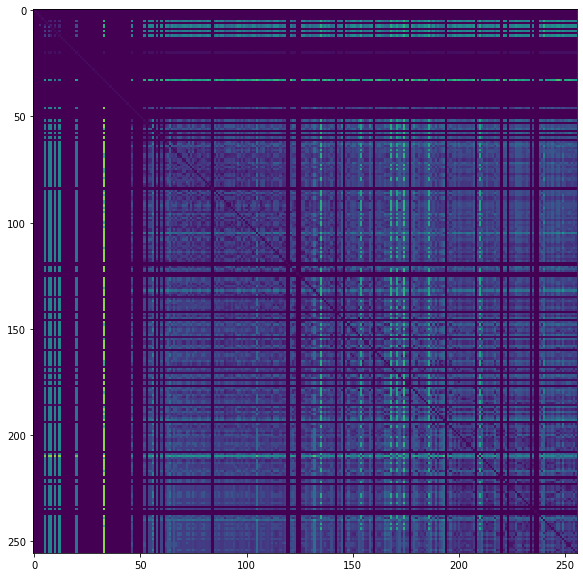

In [130]:
plt.figure(figsize=(10, 10))
plt.imshow(odt[:256, :256, 0]/odt.max())
plt.show()

In [186]:
# make pseudo-odt cube by replicating timeslices
podt = np.tile(odt[:, :, 0].reshape(npt, npt, 1), (1, 1, 10))
print(podt.shape)

(2011, 2011, 10)


In [271]:
def is_valid(a, threshold=0):
    """
    a: np.array  
    return mask indicating columns in a include values > threshold
    """
    return a.max(axis=-1) > threshold

### All locations L accessible within M minutes of a known location L1

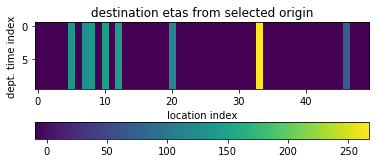

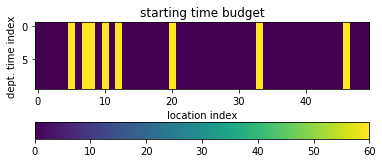

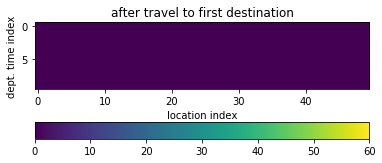

117
[54, 55, 60, 65, 70, 71, 74, 77, 78, 81, 82, 83, 86, 88, 89, 95, 96, 97, 99, 102, 103, 104, 106, 109, 110, 111, 113, 114, 115, 117, 118, 126, 127, 129, 130, 134, 136, 137, 138, 141, 144, 147, 149, 151, 152, 156, 157, 159, 161, 162, 163, 164, 169, 170, 173, 175, 176, 178, 181, 182, 183, 184, 190, 195, 198, 199, 200, 202, 203, 204, 205, 206, 207, 212, 214, 215, 218, 219, 221, 224, 226, 227, 230, 231, 233, 235, 241, 245, 246, 247, 248, 250, 251, 253, 254, 255, 256, 262, 263, 266, 276, 285, 286, 289, 290, 303, 306, 311, 320, 1946, 1951, 1952, 1953, 1954, 1967, 1968, 1980]


In [313]:
cube = podt # cube
l_idx = 0 # current location index in itinerary
origins = [150]
origin = origins[l_idx]
options = cube[origin, ...] # vertical plane through cube
valid = is_valid(options)

# initial route etas
plt.figure()
plt.imshow(np.transpose(options[:50, :]))
plt.title("destination etas from selected origin")
plt.xlabel("location index")
plt.ylabel("dept. time index")
plt.colorbar(orientation="horizontal")
plt.show()

# set time budget for each option
t_budget = 60 # minutes

# list the time spent in minutes at each destination
t_dest = [60, 30]

t_remain = np.zeros_like(options)
t_remain[valid] = t_budget

plt.figure()
plt.imshow(np.transpose(t_remain[:50, :]), vmin=0, vmax=t_budget)
plt.title("starting time budget")
plt.xlabel("location index")
plt.ylabel("dept. time index")
plt.colorbar(orientation="horizontal")
plt.show()

# travel from origin to destination
t_remain[valid] -= options[valid]
t_remain[t_remain < 0] = 0

# update valid routes
valid = is_valid(t_remain)

plt.figure()
plt.imshow(np.transpose(t_remain[:50, :]), vmin=0, vmax=t_budget)
plt.title("after travel to first destination")
plt.xlabel("location index")
plt.ylabel("dept. time index")
plt.colorbar(orientation="horizontal")
plt.show()

# list of accessible location indices
acc_idx = [i for i, v in enumerate(valid) if v]

117


### Where can I go if I want to spend M1 minutes there while also spending M2 minutes at another known location L1 before heading back to my starting location given I have a total of T minutes available

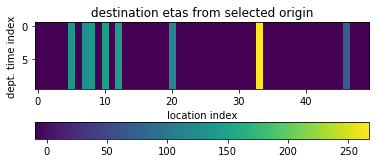

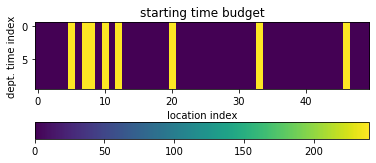

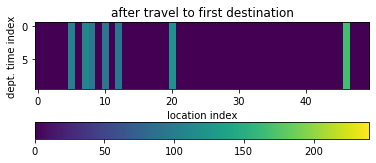

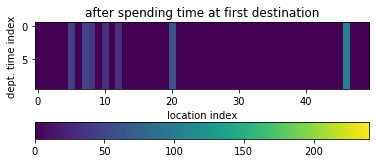

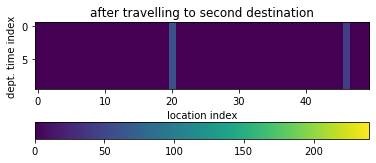

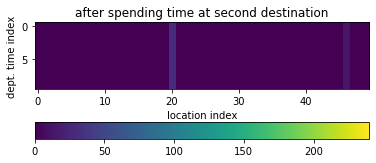

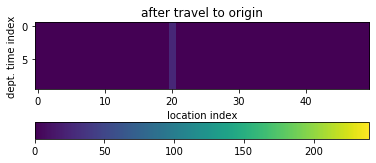

In [305]:
cube = podt # cube
l_idx = 0 # current location
origins = [150, 155]
origin = origins[l_idx]
options = cube[origin, ...] # vertical plane through cube
valid = is_valid(options)

# initial route etas
plt.figure()
plt.imshow(np.transpose(options[:50, :]))
plt.title("destination etas from selected origin")
plt.xlabel("location index")
plt.ylabel("dept. time index")
plt.colorbar(orientation="horizontal")
plt.show()


# set time budget for each option
t_budget = 4 * 60 # minutes

# list the time spent in minutes at each destination
t_dest = [60, 30]

t_remain = np.zeros_like(options)
t_remain[valid] = t_budget

plt.figure()
plt.imshow(np.transpose(t_remain[:50, :]), vmin=0, vmax=t_budget)
plt.title("starting time budget")
plt.xlabel("location index")
plt.ylabel("dept. time index")
plt.colorbar(orientation="horizontal")
plt.show()

# travel from origin to destination
t_remain[valid] -= options[valid]
t_remain[t_remain < 0] = 0

# update valid routes
valid = is_valid(t_remain)

plt.figure()
plt.imshow(np.transpose(t_remain[:50, :]), vmin=0, vmax=t_budget)
plt.title("after travel to first destination")
plt.xlabel("location index")
plt.ylabel("dept. time index")
plt.colorbar(orientation="horizontal")
plt.show()

# spend time at the first location
t_remain[valid] -= t_dest[l_idx]
t_remain[t_remain < 0] = 0

# update valid routes
valid = is_valid(t_remain)

plt.figure()
plt.imshow(np.transpose(t_remain[:50, :]), vmin=0, vmax=t_budget)
plt.title("after spending time at first destination")
plt.xlabel("location index")
plt.ylabel("dept. time index")
plt.colorbar(orientation="horizontal")
plt.show()

# travel to second location
l_idx += 1
dest = origins[l_idx]
# check for valid routes from each location
for i, r in enumerate(valid):
    if r:                
        options = cube[i, dest, :] # line through cube  
        valid[i] = is_valid(options) 

if np.any(valid):
    # subtract eta from each valid location to the destination  
    for i, r in enumerate(valid):
        if r:                       
            t_remain[i, :] -= cube[i, dest, :]        
    t_remain[t_remain < 0] = 0  
    
    # update valid routes
    valid = is_valid(t_remain)
    
    plt.figure()
    plt.imshow(np.transpose(t_remain[:50, :]), vmin=0, vmax=t_budget)
    plt.title("after travelling to second destination")
    plt.xlabel("location index")
    plt.ylabel("dept. time index")
    plt.colorbar(orientation="horizontal")
    plt.show()    
    
    # spend time at the second location
    t_remain[valid] -= t_dest[l_idx]
    t_remain[t_remain < 0] = 0

    # update valid routes
    valid = is_valid(t_remain)
    
    plt.figure()
    plt.imshow(np.transpose(t_remain[:50, :]), vmin=0, vmax=t_budget)
    plt.title("after spending time at second destination")
    plt.xlabel("location index")
    plt.ylabel("dept. time index")
    plt.colorbar(orientation="horizontal")
    plt.show()    
else:
    print(f"no valid routes found from {origin} to {dest}")

# return to origin
# cube is not symmetric so must query each destination separately
for i, r in enumerate(valid):
    if r:        
        t_remain[i, :] -= cube[i, origin, :]        
t_remain[t_remain < 0] = 0  

# update valid routes
valid = is_valid(t_remain)

plt.figure()
plt.imshow(np.transpose(t_remain[:50, :]), vmin=0, vmax=t_budget)
plt.title("after travel to origin")
plt.xlabel("location index")
plt.ylabel("dept. time index")
plt.colorbar(orientation="horizontal")
plt.show()


In [ ]:
# def travel_from(origin, cube, mask=None):
#     options = cube[origin, ...] # vertical plane through cube
#     valid = is_valid(options)
    
#     if mask:
#         valid = np.logical_and(mask, valid)
        
#     return options, valid
    
# def plot_eta(origin, options):
#     plt.figure()
#     plt.imshow(np.transpose(options))
#     plt.title(f"destination etas from {origin}")
#     plt.xlabel("location index")
#     plt.ylabel("dept. time index")
#     plt.colorbar(orientation="horizontal")
#     plt.show()
    
# def plot_budget(budget, title):
#     plt.figure()
#     plt.imshow(np.transpose(options))
#     plt.title(title)
#     plt.xlabel("location index")
#     plt.ylabel("dept. time index")
#     plt.colorbar(orientation="horizontal")
#     plt.show()
    
# cube = podt # cube

# # itinerary searches sequentially from these locations
# origins = [150, 160, 150] # for round trip calculations, the first and laste element are the same

# t_dest = [60, 30] # spend time at each location (minutes)
# t_budget = 4 * 60 # time budget in minutes

# # initalise budget from initial options
# n_points, _, n_times = cube.shape
# t_remain = np.zeros((n_points, n_times), dtype=np.float)
# initialised = False
# valid = None

# # loop through remaining origins and durations
# for o in range(0, len(origins))
    
#     # valid routes from next origin
#     origin = origins[o]
#     options, valid = travel_from(origin, mask=valid)
#     plot_eta(origin, options[:50, :]) 
    
#     # initialise budget from initial valid routes
#     if not initialised:
#         t_remain[valid] = t_budget
#         plot_budget(t_remain[:50, :], "initial budget")
#         initialised = True
    
#     # apply travel time
#     t_remain[valid] -= options[valid]
#     t_remain[t_remain < 0] = 0

#     # update valid routes
#     valid = is_valid(t_remain)    
    
#     plot_budget(t_remain[:50, :], f"after travelling to destination {o+1}")
    
#     # spend time at destination
#     t_remain[valid] -= t_dest[o]
#     t_remain[t_remain < 0] = 0

#     # update valid routes
#     valid = is_valid(t_remain)   
    
#     plot_budget(t_remain[:50, :], f"after spending time at destination {o+1}")
    
#     # travel from all valid locations to the next origin    
#     # cube is not symmetric so must query each location separately
#     for i, r in enumerate(valid):
#         if r:        
#             t_remain[i, :] -= cube[i, origin, :]        
#     t_remain[t_remain < 0] = 0  

#     # update valid routes
#     valid = is_valid(t_remain)        

In [289]:
# http://bottlepy.org/docs/dev/tutorial.html#query-variables